In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('C:/Users/shail/Desktop/project/raw data/Device-3.csv')

df.columns = ['SNo','temp','hum','co','no2','pm2_5','pm10','date']
date = df['date']
df = df.drop(["SNo"],axis=1)
df['date'] = pd.to_datetime(df['date'])

In [3]:
df.head()

,temp,hum,co,no2,pm2_5,pm10,date
0,14,49,43,1.24,68,95,2020-01-11 17:08:37
1,14,49,43,1.22,68,95,2020-01-11 17:08:19
2,14,49,43,1.20,70,97,2020-01-11 17:07:39
3,14,49,43,1.18,70,97,2020-01-11 17:07:25
4,14,49,43,1.18,70,97,2020-01-11 17:06:55


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096922 entries, 0 to 1096921
Data columns (total 7 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   temp    1096922 non-null  int64         
 1   hum     1096922 non-null  int64         
 2   co      1096922 non-null  int64         
 3   no2     1096922 non-null  float64       
 4   pm2_5   1096922 non-null  int64         
 5   pm10    1096922 non-null  int64         
 6   date    1096922 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 58.6 MB


In [6]:
df = df[(df['co'] > 0) & (df['no2'] > 0) & (df['pm2_5'] > 0) & (df['pm10'] > 0)]

In [7]:
temp_one_hr = round(df.resample('60min',on='date').temp.mean(),2)
hum_one_hr = round(df.resample('60min',on='date').hum.mean(),2)
co_one_hr = round(df.resample('60min',on='date').co.mean(),2)
no2_one_hr = round(df.resample('60min',on='date').no2.mean(),2)
pm2_5_one_hr = round(df.resample('60min',on='date').pm2_5.mean(),2)
pm10_one_hr = round(df.resample('60min',on='date').pm10.mean(),2)

one_hr_sample = pd.DataFrame({
    "TEMP":temp_one_hr,
    "HUM":hum_one_hr,
    "CO":co_one_hr,
    "NO2":no2_one_hr,
    "PM2.5":pm2_5_one_hr,
    "PM10":pm10_one_hr
})

one_hr_sample

,TEMP,HUM,CO,NO2,PM2.5,PM10
date,,,,,,
2019-09-13 16:00:00,17.69,61.16,6.32,19.40,32.73,45.76
2019-09-13 17:00:00,16.80,67.48,6.43,19.40,38.32,53.31
2019-09-13 18:00:00,17.00,66.82,6.21,19.40,27.65,38.68
2019-09-13 19:00:00,16.40,63.55,5.78,19.39,22.28,31.30
2019-09-13 20:00:00,15.73,66.26,6.06,19.39,22.89,31.97
...,...,...,...,...,...,...
2020-01-11 13:00:00,23.58,28.62,41.87,1.08,93.57,130.05
2020-01-11 14:00:00,23.81,25.91,42.29,1.07,71.30,99.06
2020-01-11 15:00:00,19.66,33.67,43.16,1.30,68.58,95.50


In [8]:
pm = one_hr_sample[['PM2.5']].copy()

In [9]:
pm

,PM2.5
date,
2019-09-13 16:00:00,32.73
2019-09-13 17:00:00,38.32
2019-09-13 18:00:00,27.65
2019-09-13 19:00:00,22.28
2019-09-13 20:00:00,22.89
...,...
2020-01-11 13:00:00,93.57
2020-01-11 14:00:00,71.30
2020-01-11 15:00:00,68.58


In [10]:
df = pm.copy()

In [11]:
#df = df[:2886]
df

,PM2.5
date,
2019-09-13 16:00:00,32.73
2019-09-13 17:00:00,38.32
2019-09-13 18:00:00,27.65
2019-09-13 19:00:00,22.28
2019-09-13 20:00:00,22.89
...,...
2020-01-11 13:00:00,93.57
2020-01-11 14:00:00,71.30
2020-01-11 15:00:00,68.58


In [12]:
df.isna().sum()

PM2.5    1187
dtype: int64

In [13]:
df = df.interpolate(method ='linear')

<AxesSubplot:xlabel='date'>

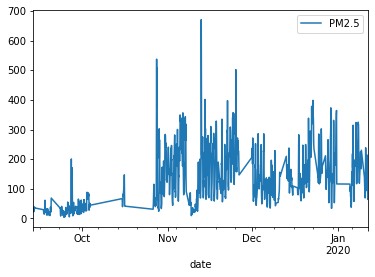

In [14]:
df.plot()

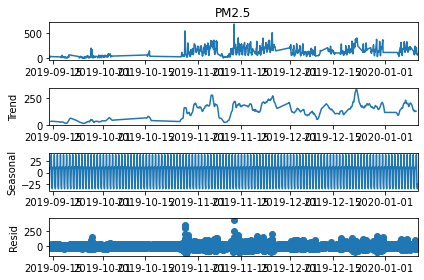

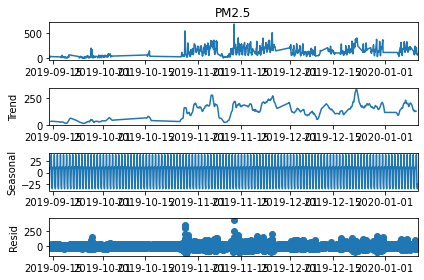

In [15]:
results = seasonal_decompose(df['PM2.5'], freq=24)
results.plot()

In [16]:
len(df)

2882

In [17]:
train = df.iloc[:2858]
test = df.iloc[2858:]

scaler = MinMaxScaler()

In [18]:
df.head(), df.tail()

(                     PM2.5
 date                      
 2019-09-13 16:00:00  32.73
 2019-09-13 17:00:00  38.32
 2019-09-13 18:00:00  27.65
 2019-09-13 19:00:00  22.28
 2019-09-13 20:00:00  22.89,
                      PM2.5
 date                      
 2020-01-11 13:00:00  93.57
 2020-01-11 14:00:00  71.30
 2020-01-11 15:00:00  68.58
 2020-01-11 16:00:00  64.05
 2020-01-11 17:00:00  70.56)

In [19]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

scaled_train[:10]

array([[0.04342874],
       [0.05180578],
       [0.03581597],
       [0.02776862],
       [0.02868275],
       [0.03376293],
       [0.03797392],
       [0.05069684],
       [0.05030721],
       [0.04516709]])

# Recursive Strategy

In [20]:
n_input = 24
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train,length=n_input,batch_size=1)

generator[0]

(array([[[0.04342874],
         [0.05180578],
         [0.03581597],
         [0.02776862],
         [0.02868275],
         [0.03376293],
         [0.03797392],
         [0.05069684],
         [0.05030721],
         [0.04516709],
         [0.05144613],
         [0.05042709],
         [0.04734003],
         [0.04722314],
         [0.04710625],
         [0.04698936],
         [0.04687247],
         [0.04675558],
         [0.04663869],
         [0.0465218 ],
         [0.04640492],
         [0.04628803],
         [0.04617114],
         [0.04605425]]]),
 array([[0.04593736]]))

In [21]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               161600    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.fit(generator, epochs=10, verbose=1)

Epoch 1/10
2834/2834 [==============================] - 63s 10ms/step - loss: 0.0052
Epoch 2/10
2834/2834 [==============================] - 29s 10ms/step - loss: 0.0016
Epoch 3/10
2834/2834 [==============================] - 29s 10ms/step - loss: 0.0016
Epoch 4/10
2834/2834 [==============================] - 30s 10ms/step - loss: 0.0015
Epoch 5/10
2834/2834 [==============================] - 30s 10ms/step - loss: 0.0013
Epoch 6/10
2834/2834 [==============================] - 29s 10ms/step - loss: 0.0013
Epoch 7/10
2834/2834 [==============================] - 30s 11ms/step - loss: 0.0013
Epoch 8/10
2834/2834 [==============================] - 30s 10ms/step - loss: 0.0013
Epoch 9/10
2834/2834 [==============================] - 30s 11ms/step - loss: 0.0012
Epoch 10/10
2834/2834 [==============================] - 30s 11ms/step - loss: 0.0015


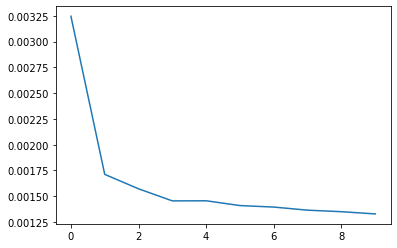

In [23]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [24]:
last_train_batch = scaled_train[-n_input:]

last_train_batch = last_train_batch.reshape((1,n_input, n_features))

model.predict(last_train_batch)

array([[0.14050412]], dtype=float32)

In [25]:
scaled_test[0], scaled_test[1]

(array([0.22339278]), array([0.29372097]))

In [26]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)
    
test_predictions

[array([0.14050412], dtype=float32),
 array([0.14316076], dtype=float32),
 array([0.14277554], dtype=float32),
 array([0.14039351], dtype=float32),
 array([0.1366076], dtype=float32),
 array([0.13184723], dtype=float32),
 array([0.12645523], dtype=float32),
 array([0.12068126], dtype=float32),
 array([0.11469512], dtype=float32),
 array([0.10859948], dtype=float32),
 array([0.10244751], dtype=float32),
 array([0.09625813], dtype=float32),
 array([0.09002915], dtype=float32),
 array([0.08375292], dtype=float32),
 array([0.077491], dtype=float32),
 array([0.07120465], dtype=float32),
 array([0.06431796], dtype=float32),
 array([0.05667392], dtype=float32),
 array([0.04832263], dtype=float32),
 array([0.0395001], dtype=float32),
 array([0.03089672], dtype=float32),
 array([0.02269281], dtype=float32),
 array([0.01511696], dtype=float32),
 array([0.00938037], dtype=float32)]

In [27]:
test.head()

,PM2.5
date,
2020-01-10 18:00:00,152.82
2020-01-10 19:00:00,199.75
2020-01-10 20:00:00,238.45
2020-01-10 21:00:00,173.36
2020-01-10 22:00:00,107.83


In [28]:
true_predictions = scaler.inverse_transform(test_predictions)

test['recursive_predict'] = true_predictions

<AxesSubplot:xlabel='date'>

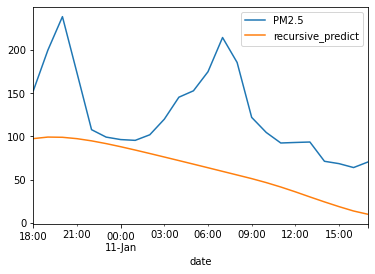

In [29]:
test.plot()

In [30]:
rmse = sqrt(mean_squared_error(test['PM2.5'], test['recursive_predict']))
print(rmse)

75.26267533418977


In [31]:
test

,PM2.5,recursive_predict
date,,
2020-01-10 18:00:00,152.82,97.508400
2020-01-10 19:00:00,199.75,99.281175
2020-01-10 20:00:00,238.45,99.024115
2020-01-10 21:00:00,173.36,97.434590
2020-01-10 22:00:00,107.83,94.908253
2020-01-10 23:00:00,99.25,91.731658
2020-01-11 00:00:00,96.39,88.133577
2020-01-11 01:00:00,95.48,84.280602
2020-01-11 02:00:00,101.92,80.286056


# Direct Startegy

In [32]:
def generate_data(data, n_input, month):
    X, y = [], []
    for i in range(0,len(data)-(n_input+month)):
            X.append(data[i:i+n_input])
            y.append(data[i+n_input+(month-1)])
    return np.array(X), np.array(y)

In [33]:
def model_predict(m_no, train_data, n_input, n_features):
    
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    X, y = generate_data(train_data, n_input, m_no)
    
    #print("MODEL : ", m_no)
    #print(X[0], y[0])
    
    model.fit(X, y, epochs=3, verbose=0)
    
    tX = train_data[-n_input:]
    
    tX = tX.reshape((1, n_input, n_features))
    
    res = model.predict(tX)
    
    return res[0]

In [34]:
n_input = 24
n_features = 1
test_predictions = []

for i in range(len(scaled_test)):
    test_predictions.append(model_predict(i+1,scaled_train,n_input, n_features))
    
test_predictions

[array([0.15217194], dtype=float32),
 array([0.17842603], dtype=float32),
 array([0.1674121], dtype=float32),
 array([0.22264825], dtype=float32),
 array([0.19734855], dtype=float32),
 array([0.24130952], dtype=float32),
 array([0.19153963], dtype=float32),
 array([0.18126744], dtype=float32),
 array([0.23506139], dtype=float32),
 array([0.22180118], dtype=float32),
 array([0.26256877], dtype=float32),
 array([0.22498403], dtype=float32),
 array([0.20678164], dtype=float32),
 array([0.19417734], dtype=float32),
 array([0.18439886], dtype=float32),
 array([0.23728584], dtype=float32),
 array([0.15297526], dtype=float32),
 array([0.16301557], dtype=float32),
 array([0.14636408], dtype=float32),
 array([0.13727893], dtype=float32),
 array([0.13417973], dtype=float32),
 array([0.14508669], dtype=float32),
 array([0.12687624], dtype=float32),
 array([0.15577379], dtype=float32)]

In [35]:
true_predictions = scaler.inverse_transform(test_predictions)

test['direct_predict'] = true_predictions

<AxesSubplot:xlabel='date'>

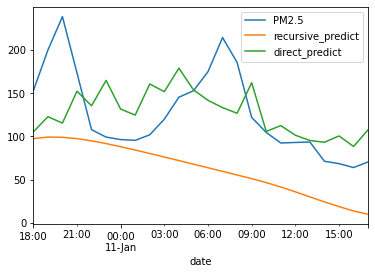

In [36]:
test.plot()

In [37]:
rmse = sqrt(mean_squared_error(test['PM2.5'], test['direct_predict']))
print(rmse)

47.05424501800697


In [38]:
test

,PM2.5,recursive_predict,direct_predict
date,,,
2020-01-10 18:00:00,152.82,97.508400,105.294335
2020-01-10 19:00:00,199.75,99.281175,122.813688
2020-01-10 20:00:00,238.45,99.024115,115.464096
2020-01-10 21:00:00,173.36,97.434590,152.323176
2020-01-10 22:00:00,107.83,94.908253,135.440687
2020-01-10 23:00:00,99.25,91.731658,164.775845
2020-01-11 00:00:00,96.39,88.133577,131.564395
2020-01-11 01:00:00,95.48,84.280602,124.709763
2020-01-11 02:00:00,101.92,80.286056,160.606467


# Direct Recursive Startegy

In [39]:
def generate_data(data, n_input, month):
    X, y = [], []
    for i in range(0,len(data)-(n_input+month)):
            X.append(data[i:i+n_input+(month-1)])
            y.append(data[i+n_input+(month-1)])
    return np.array(X), np.array(y)

In [40]:
def model_predict(m_no, train_data, n_input, n_features):
    
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_input+(m_no - 1), n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    X, y = generate_data(train_data, n_input, m_no)
    #print(y.dtype)
    
    #print("Model No.  - ", m_no)
    #print(X[0], y[0])
    #print("SHAPE XY : ", X.shape, y.shape)
    
    model.fit(X, y, epochs=3, verbose=0)
    
    tX = train_data[-n_input:]
    tP = np.array(test_predictions)
    
    tX = np.concatenate((tX, tP), axis=None)
    
    #print("TYPE : ", type(tX), type(tP))
    
    #print("TX : ", tX)
        
    #print("SHAPE : " , tX.shape)
    
    tX = tX.reshape((1, tX.shape[0], n_features))
    
    res = model.predict(tX)
    
    return res[0]

In [41]:
n_input = 24
n_features = 1
test_predictions = []

for i in range(len(scaled_test)):
    pred = model_predict(i+1,scaled_train,n_input, n_features)
    test_predictions.append(pred)
    
test_predictions

[array([0.12044968], dtype=float32),
 array([0.15317869], dtype=float32),
 array([0.14912018], dtype=float32),
 array([0.14505056], dtype=float32),
 array([0.16824582], dtype=float32),
 array([0.18679388], dtype=float32),
 array([0.22700843], dtype=float32),
 array([0.22106019], dtype=float32),
 array([0.22668165], dtype=float32),
 array([0.22715999], dtype=float32),
 array([0.23160799], dtype=float32),
 array([0.2288967], dtype=float32),
 array([0.30765626], dtype=float32),
 array([0.24234687], dtype=float32),
 array([0.25045663], dtype=float32),
 array([0.25042734], dtype=float32),
 array([0.22093485], dtype=float32),
 array([0.22908293], dtype=float32),
 array([0.22728595], dtype=float32),
 array([0.22301435], dtype=float32),
 array([0.21119915], dtype=float32),
 array([0.2119728], dtype=float32),
 array([0.2108076], dtype=float32),
 array([0.21441355], dtype=float32)]

In [42]:
true_predictions = scaler.inverse_transform(test_predictions)

test['direct_recursive_predict'] = true_predictions

<AxesSubplot:xlabel='date'>

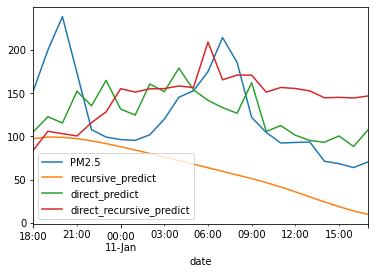

In [43]:
test.plot()

In [44]:
rmse = sqrt(mean_squared_error(test['PM2.5'], test['direct_recursive_predict']))
print(rmse)

61.975291253175165


In [45]:
test

,PM2.5,recursive_predict,direct_predict,direct_recursive_predict
date,,,,
2020-01-10 18:00:00,152.82,97.508400,105.294335,84.126075
2020-01-10 19:00:00,199.75,99.281175,122.813688,105.966141
2020-01-10 20:00:00,238.45,99.024115,115.464096,103.257897
2020-01-10 21:00:00,173.36,97.434590,152.323176,100.542236
2020-01-10 22:00:00,107.83,94.908253,135.440687,116.020437
2020-01-10 23:00:00,99.25,91.731658,164.775845,128.397555
2020-01-11 00:00:00,96.39,88.133577,131.564395,155.232727
2020-01-11 01:00:00,95.48,84.280602,124.709763,151.263463
2020-01-11 02:00:00,101.92,80.286056,160.606467,155.014665


# MIMO

In [46]:
def generate_data(data, n_input, n_output):
    X, y = [], []
    for i in range(0,len(data)-(n_input+n_output)):
            X.append(data[i:(i+n_input)])
            y.append(data[i+n_input: i+n_input+n_output])
    return np.array(X), np.array(y)

In [47]:
n_input = 24
n_features = 1
n_output = len(scaled_test)

X, y = generate_data(scaled_train, n_input, n_output)

In [48]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(n_output))
model.compile(optimizer='adam', loss='mse')

In [49]:
model.fit(X, y, epochs=3, verbose=0)

In [50]:
model.summary()

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_49 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_49 (Dense)             (None, 24)                4824      
Total params: 166,424
Trainable params: 166,424
Non-trainable params: 0
_________________________________________________________________


In [51]:
tX = scaled_train[-n_input:]
tX = tX.reshape((1, tX.shape[0], n_features))

res = model.predict(tX)

res = res.reshape((res.shape[1],1))

In [52]:
res.shape

(24, 1)

In [53]:
true_predictions = scaler.inverse_transform(res)

test['MIMO_predict'] = true_predictions

In [54]:
test

,PM2.5,recursive_predict,direct_predict,direct_recursive_predict,MIMO_predict
date,,,,,
2020-01-10 18:00:00,152.82,97.508400,105.294335,84.126075,114.530678
2020-01-10 19:00:00,199.75,99.281175,122.813688,105.966141,136.377213
2020-01-10 20:00:00,238.45,99.024115,115.464096,103.257897,144.604919
2020-01-10 21:00:00,173.36,97.434590,152.323176,100.542236,157.933136
2020-01-10 22:00:00,107.83,94.908253,135.440687,116.020437,167.994446
2020-01-10 23:00:00,99.25,91.731658,164.775845,128.397555,171.147125
2020-01-11 00:00:00,96.39,88.133577,131.564395,155.232727,171.783203
2020-01-11 01:00:00,95.48,84.280602,124.709763,151.263463,170.118774
2020-01-11 02:00:00,101.92,80.286056,160.606467,155.014665,175.395584


<AxesSubplot:xlabel='date'>

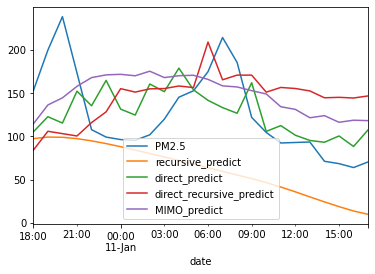

In [55]:
test.plot()

In [56]:
rmse = sqrt(mean_squared_error(test['PM2.5'], test['MIMO_predict']))
print(rmse)

51.83468699759117


# Direct MIMO

In [57]:
def generate_data(data, n_input, q_no, n_output):
    X, y = [], []
    for i in range(0,len(data)-(n_input + ((q_no-1)*n_output) + n_output)):
            X.append(data[i:(i+n_input)])
            y.append(data[i+n_input+((q_no-1)*n_output): i+n_input+((q_no-1)*n_output) + n_output])
    return np.array(X), np.array(y)

In [58]:
def model_predict(train_data, n_input, n_features, q_no, n_output):
    
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(n_output))
    model.compile(optimizer='adam', loss='mse')
    
    X, y = generate_data(train_data, n_input, q_no, n_output)
    
    model.fit(X, y, epochs=3, verbose=0)
    
    tX = train_data[-n_input:]
    
    tX = tX.reshape((1, n_input, n_features))
    
    res = model.predict(tX)
    
    return res

In [59]:
n_input = 12
n_features = 1
test_predictions = []

q = int(len(scaled_test)/4)

n_output = q

for i in range(q):
    pred = model_predict(scaled_train,n_input, n_features, i+1, n_output)
    test_predictions.append(pred)

test_predictions

[array([[0.15134218, 0.15751542, 0.15620682, 0.15714797, 0.15786693,
         0.16806997]], dtype=float32),
 array([[0.21080735, 0.21630871, 0.2178929 , 0.21435559, 0.21608041,
         0.22576731]], dtype=float32),
 array([[0.19181749, 0.19476914, 0.2006101 , 0.20394443, 0.19754007,
         0.2001457 ]], dtype=float32),
 array([[0.1447088 , 0.13293263, 0.14366351, 0.14140585, 0.13908301,
         0.13740514]], dtype=float32),
 array([[0.17592882, 0.17795551, 0.1849135 , 0.18346827, 0.18381971,
         0.18152133]], dtype=float32),
 array([[0.20043384, 0.20486231, 0.2075672 , 0.20156066, 0.20828491,
         0.21214594]], dtype=float32)]

In [60]:
res = []

for i in test_predictions:
    for j in i:
        for k in j:
            res.append(k)

In [61]:
res = np.array(res[:len(scaled_test)])
res = res.reshape((res.shape[0],1))
res.shape

(24, 1)

In [62]:
true_predictions = scaler.inverse_transform(res)

test['Direct_MIMO_predict'] = true_predictions

In [63]:
test

,PM2.5,recursive_predict,direct_predict,direct_recursive_predict,MIMO_predict,Direct_MIMO_predict
date,,,,,,
2020-01-10 18:00:00,152.82,97.508400,105.294335,84.126075,114.530678,104.740639
2020-01-10 19:00:00,199.75,99.281175,122.813688,105.966141,136.377213,108.860039
2020-01-10 20:00:00,238.45,99.024115,115.464096,103.257897,144.604919,107.986809
2020-01-10 21:00:00,173.36,97.434590,152.323176,100.542236,157.933136,108.614845
2020-01-10 22:00:00,107.83,94.908253,135.440687,116.020437,167.994446,109.094597
2020-01-10 23:00:00,99.25,91.731658,164.775845,128.397555,171.147125,115.903091
2020-01-11 00:00:00,96.39,88.133577,131.564395,155.232727,171.783203,144.421753
2020-01-11 01:00:00,95.48,84.280602,124.709763,151.263463,170.118774,148.092804
2020-01-11 02:00:00,101.92,80.286056,160.606467,155.014665,175.395584,149.149933


<AxesSubplot:xlabel='date'>

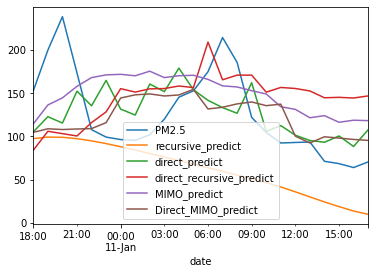

In [64]:
test.plot()

In [65]:
rmse = sqrt(mean_squared_error(test['PM2.5'], test['Direct_MIMO_predict']))
print(rmse)

48.91850847998071


In [66]:
rec_err = abs(test['PM2.5'] - test['recursive_predict'])
dir_err = abs(test['PM2.5'] - test['direct_predict'])
dir_rec_err = abs(test['PM2.5'] - test['direct_recursive_predict'])
mimo_err = abs(test['PM2.5'] - test['MIMO_predict'])
dir_mimo_err = abs(test['PM2.5'] - test['Direct_MIMO_predict'])

In [67]:
errors = pd.DataFrame({
    'Recursive':rec_err,
    'Direct':dir_err,
    'Direct Recursive':dir_rec_err,
    'MIMO':mimo_err,
    'Direct MIMO':dir_mimo_err
})

In [68]:
errors

,Recursive,Direct,Direct Recursive,MIMO,Direct MIMO
date,,,,,
2020-01-10 18:00:00,55.311600,47.525665,68.693925,38.289322,48.079361
2020-01-10 19:00:00,100.468825,76.936312,93.783859,63.372787,90.889961
2020-01-10 20:00:00,139.425885,122.985904,135.192103,93.845081,130.463191
2020-01-10 21:00:00,75.925410,21.036824,72.817764,15.426864,64.745155
2020-01-10 22:00:00,12.921747,27.610687,8.190437,60.164446,1.264597
2020-01-10 23:00:00,7.518342,65.525845,29.147555,71.897125,16.653091
2020-01-11 00:00:00,8.256423,35.174395,58.842727,75.393203,48.031753
2020-01-11 01:00:00,11.199398,29.229763,55.783463,74.638774,52.612804
2020-01-11 02:00:00,21.633944,58.686467,53.094665,73.475584,47.229933


<AxesSubplot:xlabel='date'>

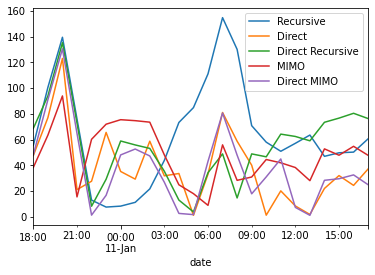

In [69]:
errors.plot()

In [70]:
len(scaled_test)

24